In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import os
import copy
import argparse
import random
import numpy as np
plt.ion()   # interactive mode

In [2]:
img_size = 64
data_dir = '../ssl_data_96/supervised'
batch_size = 16
manual_seed = 6000
cudnn.benchmark = True
num_workers = 4
ngpu = int(0)
is_cuda = False
net_weights_path = '/home/raghavjajodia/Documents/tempdir2/netD_epoch_6.pth'
ndf = 64
lr = 0.001
beta1 = 0.5
top_k = 5

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'val': transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

assert image_datasets

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= batch_size,
                                              shuffle=True, num_workers=num_workers)
                  for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

if torch.cuda.is_available() and not is_cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda:0" if is_cuda else "cpu")

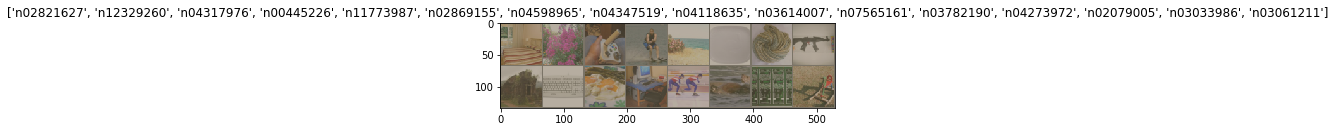

In [4]:
#Code for jupyter notebook
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
######################################################################
# Training the model
# ------------------
#
# Now, let's write a general function to train a model. Here, we will
# illustrate:
#
# -  Scheduling the learning rate
# -  Saving the best model
#
# In the following, parameter ``scheduler`` is an LR scheduler object from
# ``torch.optim.lr_scheduler``.

#General Code for supervised train
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_correct_top5 = 0
            n_samples = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                batch_size = inputs.size(0)
                n_samples += batch_size

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                pred_top_1 = torch.topk(outputs, k=1, dim=1)[1]
                running_corrects += pred_top_1.eq(labels.view_as(pred_top_1)).int().sum().item()

                # Top k accuracy
                pred_top_k = torch.topk(outputs, k=top_k, dim=1)[1]
                target_top_k = labels.view(-1, 1).expand(batch_size, top_k)
                running_correct_top5 += pred_top_k.eq(target_top_k).int().sum().item()
                
            # Accuracy
            top_1_acc = running_corrects/n_samples
            top_k_acc = running_correct_top5/n_samples

            epoch_loss = running_loss / n_samples

            print('{} Loss: {:.4f} Top 1 Acc: {:.4f} Top k Acc: {:.4f}'.format(
                phase, epoch_loss, top_1_acc, top_k_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
######################################################################
# Visualizing the model predictions
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Generic function to display predictions for a few images
#

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
# ######################################################################
# # Finetuning the convnet
# # ----------------------
# #
# # Load a pretrained model and reset final fully connected layer.
# #

# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 2)

# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
# ######################################################################
# # Train and evaluate
# # ^^^^^^^^^^^^^^^^^^
# #
# # It should take around 15-25 min on CPU. On GPU though, it takes less than a
# # minute.
# #

# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=25)

# ######################################################################
# #

# visualize_model(model_ft)

In [21]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class Discriminator(nn.Module):
    def __init__(self, ngpu, num_class):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (3) x 64 x 64
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (opt.ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (opt.ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (opt.ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
            # state size, (opt.ndf * 8) X 4 X 4
        )
        self.classif = nn.Sequential(
            nn.Conv2d(ndf * 8, ndf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size, (opt.ndf * 16) X 1 X 1
            Flatten(),
            nn.Dropout(p=0.6),
            nn.Linear(ndf * 16, ndf * 20),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.8),
            nn.Linear(ndf * 20, num_class)
        )

    def forward(self, input):
        if input.cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
            output2 = nn.parallel.data_parallel(self.classif, output, range(self.ngpu))
        else:
            output = self.main(input)
            output2 = self.classif(output)
        return output2

In [22]:
# class Old_Discriminator(nn.Module):
#     def __init__(self, ngpu):
#         super(Old_Discriminator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is (3) x 64 x 64
#             nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 32 x 32
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 16 x 16
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 8 x 8
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 4 x 4
#             nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         if input.is_cuda and self.ngpu > 1:
#             output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
#         else:
#             output = self.main(input)

#         return output.view(-1, 1).squeeze(1)

In [25]:
######################################################################
# ConvNet as fixed feature extractor
# ----------------------------------
#
# Here, we need to freeze all the network except the final layer. We need
# to set ``requires_grad == False`` to freeze the parameters so that the
# gradients are not computed in ``backward()``.
#
# You can read more about this in the documentation
# `here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.
#

netD = Discriminator(1, len(class_names)).to(device)
netD.load_state_dict(torch.load(net_weights_path, map_location=device), strict=False)

for param in netD.parameters():
    param.requires_grad = False
    
for param in netD.classif.parameters():
    param.requires_grad = True

In [26]:
netD.main[11]

IndexError: index 11 is out of range

In [28]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(netD.classif.parameters(), lr=0.001, betas=(beta1, 0.999))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [97]:
######################################################################
# Train and evaluate
# ^^^^^^^^^^^^^^^^^^
#
# On CPU this will take about half the time compared to previous scenario.
# This is expected as gradients don't need to be computed for most of the
# network. However, forward does need to be computed.
#

netD = train_model(netD, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

######################################################################
#

visualize_model(model_conv)

plt.ioff()
plt.show()

Epoch 0/24
----------
batch stats
train Loss: 7.0485 Top 1 Acc: 0.0000 Top k Acc: 0.0000
batch stats
train Loss: 7.1816 Top 1 Acc: 0.0000 Top k Acc: 0.0312
batch stats
train Loss: 7.6900 Top 1 Acc: 0.0000 Top k Acc: 0.0208
batch stats
train Loss: 7.9697 Top 1 Acc: 0.0000 Top k Acc: 0.0156
batch stats
train Loss: 8.2138 Top 1 Acc: 0.0000 Top k Acc: 0.0125
batch stats
train Loss: 8.2918 Top 1 Acc: 0.0000 Top k Acc: 0.0208
batch stats
train Loss: 8.3884 Top 1 Acc: 0.0000 Top k Acc: 0.0179
batch stats
train Loss: 8.4085 Top 1 Acc: 0.0000 Top k Acc: 0.0156
batch stats
train Loss: 8.4097 Top 1 Acc: 0.0069 Top k Acc: 0.0208
batch stats
train Loss: 8.3978 Top 1 Acc: 0.0063 Top k Acc: 0.0187
batch stats
train Loss: 8.4473 Top 1 Acc: 0.0057 Top k Acc: 0.0170
batch stats
train Loss: 8.5026 Top 1 Acc: 0.0052 Top k Acc: 0.0156
batch stats
train Loss: 8.4524 Top 1 Acc: 0.0048 Top k Acc: 0.0144
batch stats
train Loss: 8.4707 Top 1 Acc: 0.0045 Top k Acc: 0.0134
batch stats
train Loss: 8.5206 Top 1 Acc

Traceback (most recent call last):
  File "/home/raghavjajodia/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/raghavjajodia/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/raghavjajodia/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/raghavjajodia/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 